In [83]:
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import os
import cv2 as cv

In [2]:
def register():
    output_dir = "../HaN-Seg Registered"

    for i in range(1, 43):
        case_num = f"{i:02d}"
        filepath_ct = f"../HaN-Seg/set_1/case_{case_num}/case_{case_num}_IMG_CT.nrrd"
        filepath_mri = f"../HaN-Seg/set_1/case_{case_num}/case_{case_num}_IMG_MR_T1.nrrd"
        ct = sitk.ReadImage(filepath_ct, sitk.sitkFloat32)
        mri = sitk.ReadImage(filepath_mri, sitk.sitkFloat32)
        
        # Registers the MRI image to the CT image
        mri_registered = register_helper(ct, mri)

        # Saves image to the HaN-Seg Registration Folder
        output_path = os.path.join(output_dir, f"MRI_Case_{case_num}.nrrd")
        sitk.WriteImage(mri_registered, output_path)

    return


# Add notation here
def register_helper(fixed_image, moving_image):

    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY,
    )

    min_value = float(sitk.GetArrayViewFromImage(moving_image).min())
    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        initial_transform,
        sitk.sitkLinear,
        min_value,
        moving_image.GetPixelID(),
    )

    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration_method.Execute(
        sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
    )

    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        final_transform,
        sitk.sitkLinear,
        min_value,
        moving_image.GetPixelID(),
    )
    return moving_resampled

In [20]:
register()

In [ ]:
def pruneVolume():
    output_dir = "../HaN-Seg Pruned"
    for i in range(1, 43):
        case_num = f"{i:02d}"
        filepath_mri = f"../HaN-Seg Registered/MRI_Case_{case_num}.nrrd"
        mri = sitk.ReadImage(filepath_mri, sitk.sitkFloat32)
        mri = sitk.GetArrayViewFromImage(mri).astype(np.float32)

        filepath = f"../HaN-Seg/set_1/case_{case_num}/case_{case_num}_OAR_Bone_Mandible.seg.nrrd"
        gt = sitk.ReadImage(filepath, sitk.sitkFloat32)
        gt = sitk.GetArrayViewFromImage(gt).astype(np.float32)

        gt_var = np.var(gt, axis = (1, 2))
        mask = gt_var > 1e-10
        mri = mri[mask]
        mri = sitk.GetImageFromArray(mri)
        gt = gt[mask]
        gt = sitk.GetImageFromArray(gt)

        output_path = os.path.join(output_dir, "MRI", f"MRI_Case_{case_num}.nrrd")
        sitk.WriteImage(mri, output_path)

        output_path = os.path.join(output_dir, "GT", f"GT_Case_{case_num}.nrrd")
        sitk.WriteImage(gt, output_path)

In [25]:
pruneVolume()

In [ ]:
def histEqual():
    output_dir = "../HaN-Seg Hist Eq"
    for i in range(1, 43):
        case_num = f"{i:02d}"
        filepath_mri = f"../HaN-Seg Pruned/MRI/MRI_Case_{case_num}.nrrd"
        mri = sitk.ReadImage(filepath_mri, sitk.sitkFloat32)
        mri_arr = sitk.GetArrayFromImage(mri)
        np.linspace(min(mri_arr), max(mri_arr), )

        matcher = sitk.HistogramMatchingImageFilter()
        matcher.SetNumberOfHistogramLevels(256)
        matcher.SetNumberOfMatchPoints(256)
        
                
        mri = matcher.Execute(mri, mri)

        output_path = os.path.join(output_dir, f"MRI_Case_{case_num}.nrrd")
        sitk.WriteImage(mri, output_path)

In [97]:
histEqual()

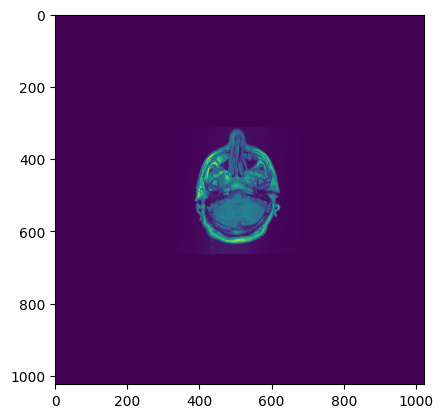

In [ ]:
test1 = sitk.ReadImage("../HaN-Seg Registered/MRI_Case_28.nrrd", sitk.sitkFloat32)
test3 = sitk.ReadImage("../HaN-Seg Normalized/MRI_Case_28.nrrd", sitk.sitkFloat32)
test = sitk.ReadImage("../HaN-Seg Hist Eq/MRI_Case_28.nrrd", sitk.sitkFloat32)
test2 = sitk.ReadImage("../HaN-Seg Pruned/MRI/MRI_Case_28.nrrd", sitk.sitkFloat32)
test = sitk.GetArrayFromImage(test)
test2 = sitk.GetArrayFromImage(test2)
test3 = sitk.GetArrayFromImage(test3)
test1 = sitk.GetArrayFromImage(test1)

i = 5
# fig, axes = plt.subplots(1, 4)
# axes[0].imshow(test[i])
# axes[1].imshow(test1[i])
# axes[2].imshow(test2[i])
# axes[3].imshow(test3[i])

In [79]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

BATCH_SIZE = 16
BUFFER_SIZE = 1000
RANDOM_SEED = 42
IMAGE_RESIZE = 512

In [ ]:
def normalize():
    output_dir = "../HaN-Seg Normalized"
    img_sum = 0.0
    img_sq_sum = 0.0
    total = 0
    for i in range(1, 43):
        case_num = f"{i:02d}"
        filepath = f"../HaN-Seg Hist Eq/MRI_Case_{case_num}.nrrd"
        mri = sitk.ReadImage(filepath, sitk.sitkFloat32)
        mri = sitk.GetArrayViewFromImage(mri).astype(np.float32)
        img_sum += np.sum(mri)
        img_sq_sum += np.sum(mri ** 2)
        total += mri.size
    
    train_mean = img_sum/total
    train_sd = np.sqrt(img_sq_sum/total - (train_mean**2))

    for i in range(1, 43):
        case_num = f"{i:02d}"
        filepath = f"../HaN-Seg Hist Eq/MRI_Case_{case_num}.nrrd"
        mri = sitk.ReadImage(filepath, sitk.sitkFloat32)
        mri = sitk.GetArrayViewFromImage(mri).astype(np.float32)
    
        normalized = (mri - train_mean) / train_sd
        normalized = sitk.GetImageFromArray(normalized)
        output_path = os.path.join(output_dir, f"MRI_Case_{case_num}.nrrd")
        sitk.WriteImage(normalized, output_path)

    return train_mean, train_sd

In [78]:
def load_images(img_path, mask_path):
    img_path = img_path.numpy().decode("utf-8")
    mask_path = mask_path.numpy().decode("utf-8")

    mri = sitk.ReadImage(img_path, sitk.sitkFloat32)
    gt = sitk.ReadImage(mask_path, sitk.sitkFloat32)

    slices = sitk.GetArrayViewFromImage(mri).astype(np.float32)
    slices_gt = sitk.GetArrayViewFromImage(gt).astype(np.float32)

    slices_resize = np.expand_dims(slices, axis=-1)
    slices_gt_resize = np.expand_dims(slices_gt, axis=-1)

    slices_resize = tf.image.resize(slices_resize, [IMAGE_RESIZE, IMAGE_RESIZE], method=tf.image.ResizeMethod.BILINEAR)
    slices_gt_resize = tf.image.resize(slices_gt_resize, [IMAGE_RESIZE, IMAGE_RESIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return slices_resize, slices_gt_resize

def lammy_func(img_path, mask_path):
    img, mask = tf.py_function(
        func=load_images,
        inp=[img_path, mask_path],
        Tout=[tf.float32, tf.float32]
    )
    img.set_shape([None, IMAGE_RESIZE, IMAGE_RESIZE, 1])
    mask.set_shape([None, IMAGE_RESIZE, IMAGE_RESIZE, 1])
    return img, mask

In [48]:
img_path = []
gt_path = []

train_mean, train_sd = normalize()

for i in range(1, 43):
    case_num = f"{i:02d}"
    filepath_mri = f"../HaN-Seg Normalized/MRI_Case_{case_num}.nrrd"
    img_path.append(filepath_mri)
    filepath_gt = f"../HaN-Seg Pruned/GT/GT_Case_{case_num}.nrrd"
    gt_path.append(filepath_gt)

X_train, X_test, y_train, y_test = train_test_split(img_path, gt_path, test_size=0.2, random_state=RANDOM_SEED)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_dataset = (
    train_dataset
    .map(lammy_func, num_parallel_calls=tf.data.AUTOTUNE)
    .unbatch()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

test_dataset = (
    test_dataset
    .map(lammy_func, num_parallel_calls=tf.data.AUTOTUNE)
    .unbatch()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

In [65]:
## A single Encoding step in the Contracting path of a U-Net CNN
## @Inputs:
##       inputs: image of size (nxn) with k feature channels
##       num_channels: number of channels to have in output image (i.e. depth of output tensor)
## @Outputs: 
##       x: image of size (n/2 x n/2) with num_channels feature channels
def encode_block(inputs, num_channels):
    # Extract num_channels feature channels from image
    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    skip = tf.keras.layers.Activation('relu')(x)

    # Downsample each channels feature map by a factor of 2
    x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(skip)

    return skip, x

## A single Decoding step in the Expanding path of a U-Net CNN
## @Inputs:
##       inputs: image of size (nxn) with k feature channels
##       skip_connection: tensor of corresponding encoding block
##       num_channels: number of channels to have in output image (i.e. depth of output tensor)
## @Outputs: 
##       x: image of size (2nx2n) with num_channels feature channels
def decode_block(inputs, skip_connection, num_channels):
    # Upsample image by doubling feature space while changing feature channels to num_channels
    x = tf.keras.layers.Conv2DTranspose(num_channels, (2,2), strides=2, padding='same')(inputs)

    # Concatonate the skip_channel and the upsampled image (doubles the feature channels)
    # Might need to resize skip_connection, but should be fine b/c same padding in encoding
    x = tf.keras.layers.Concatenate()([x, skip_connection])
    
    # Merge feature channels from the skip_connection and upsampled input image
    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

# Metrics
# Source: https://medium.com/mastering-data-science/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f
def dice_coeff(y_true, y_pred):
    epsilon = 1e-6
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    return (2*tp+epsilon)/(2*tp + fp + fn+epsilon)

def rand_index(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    return tp / (tp + fp + fn)

def jaccard_index(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))
    return (tp + tn) / (tp + tn + fn + fp)

def specificity(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))
    possible_negatives = tf.reduce_sum(tf.cast(1 - y_true, tf.float32))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

In [75]:
## Defining the model

input = tf.keras.layers.Input(shape=(IMAGE_RESIZE, IMAGE_RESIZE, 1))

# Do 5 calls of encode_block to end up with a 32x32x512 tensor
s1, e1 = encode_block(input, 32)
s2, e2 = encode_block(e1, 64)
s3, e3 = encode_block(e2, 128)
s4, e4 = encode_block(e3, 256)
s5, e5 = encode_block(e4, 512)

# Bottleneck
b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(e5)
b1 = tf.keras.layers.Activation('relu')(b1)
b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(b1)
b1 = tf.keras.layers.Activation('relu')(b1)

# b1 = tf.keras.layers.Conv2D(512, 3, padding='same')(e4)
# b1 = tf.keras.layers.Activation('relu')(b1)
# b1 = tf.keras.layers.Conv2D(512, 3, padding='same')(b1)
# b1 = tf.keras.layers.Activation('relu')(b1)

# Do 5 calls of decode_block
d1 = decode_block(b1, s5, 512)
d2 = decode_block(d1, s4, 256)
d3 = decode_block(d2, s3, 128)
d4 = decode_block(d3, s2, 64)
d5 = decode_block(d4, s1, 32)

# Play around with activation
output = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d5)

model = tf.keras.models.Model(inputs=input, outputs=output, name='U-Net')

model.compile(
    optimizer = 'adam',
    loss=custom_loss,
    metrics=['accuracy', dice_coeff, specificity, rand_index, jaccard_index]
)

In [82]:
def custom_loss(y_true, y_pred):
    dice_weight = 10.0
    bce_weight = 1.0
    bce = tf.keras.losses.BinaryCrossentropy()
    loss_dice = 1.0 - dice_coeff(y_true, y_pred)
    loss_bce = bce(y_true, y_pred)
    loss = dice_weight * loss_dice + bce_weight * loss_bce

    tf.print("BCE:", loss_bce, "Dice loss:", loss_dice)
    return loss

In [77]:
EPOCH = 4
model.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs = EPOCH,
    steps_per_epoch = len(X_train) // BATCH_SIZE
    )

Epoch 1/4
BCE: 1.09989643 Dice loss: 0.98889184
1/2 ━━━━━━━━━━━━━━━━━━━━ 19s 20s/step - accuracy: 0.1556 - dice_coeff: 0.0111 - jaccard_index: 0.4049 - loss: 1.0222 - rand_index: 0.0056 - specificity: 0.4031BCE: 0.942258239 Dice loss: 0.998400688
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1266 - dice_coeff: 0.0087 - jaccard_index: 0.4101 - loss: 1.0120 - rand_index: 0.0044 - specificity: 0.4087 BCE: 0.693223238 Dice loss: 0.994361877
BCE: 0.693221092 Dice loss: 0.996074855
BCE: 0.693237364 Dice loss: 0.998225152
BCE: 0.693247199 Dice loss: 0.995165467
BCE: 0.693225443 Dice loss: 0.996568143
BCE: 0.69321537 Dice loss: 0.996810913
BCE: 0.69322592 Dice loss: 0.990542
BCE: 0.6932109 Dice loss: 0.997388482
BCE: 0.695032299 Dice loss: 0.994447351


KeyboardInterrupt: 

In [ ]:
model.save('../Model/u-net_cnn.keras')

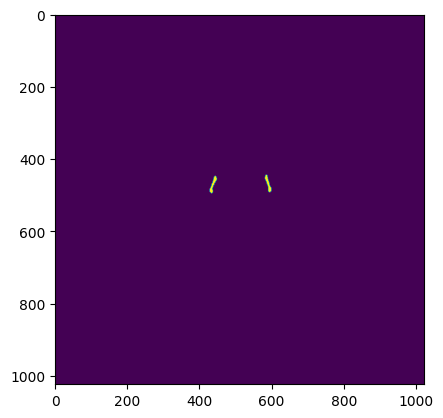

In [ ]:
test = sitk.ReadImage("../HaN-Seg Pruned/GT/GT_Case_04.nrrd")
test = sitk.GetArrayViewFromImage(test).astype(np.float32)

plt.imshow(test[30])

#TODO binary crossentropy + dice loss or focal loss